Questo notebook viene utilizzato solo in fase di sviluppo per testare nuove features

In [36]:
import cv2 as cv
import sys
from matplotlib import pyplot as plt
import numpy as np
import colorsys
import imutils
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from preset import Preset

Mask from image

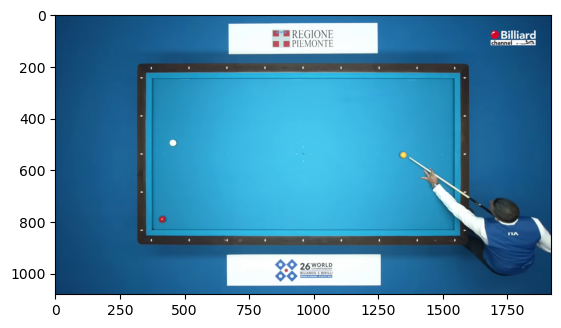

In [53]:
img = cv.imread(cv.samples.findFile("test3.png")) # imread legge l'immagine in BGR e non in RGB, quindi il rosso e il blu sono invertiti
if img is None:
    sys.exit("Could not read the image.")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

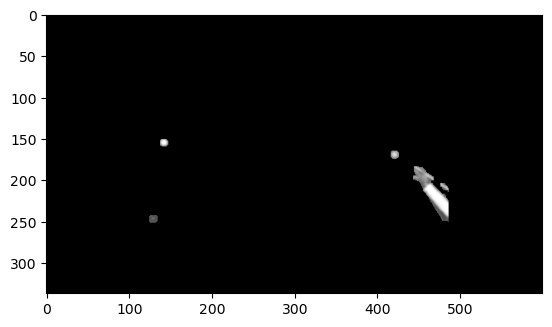

In [ ]:
frame = imutils.resize(img, width=600)
scale_factor = 600 / img.shape[1]
blurred = cv.GaussianBlur(frame, (5, 5), 0)
hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

preset1 = Preset(
    [(713, 362), (1180, 360), (1364, 907), (525, 905)],
    ["#4895b4", "#4e9ab8", "#3a6f9b"],
)

preset2 = Preset(
    [(365,845), (365,235), (1556,240), (1556,845)],
    ["#45c6ed", "#2288b5", "#1978a2"],
)

points = preset2.points
table_colors_hex = preset2.colors

points = np.array(points, dtype=np.float32) * scale_factor
points = points.astype(np.int32)


# Convert hex colors to HSV

table_colors = []

for color in table_colors_hex:

    r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)

    h, s, v = colorsys.rgb_to_hsv(r / 255, g / 255, b / 255)

    table_colors.append([int(h * 178), int(s * 255), int(v * 255)])

h_diff = 5

s_diff = 10

v_diff = 5

color_lower = (
    min(color[0] for color in table_colors) - h_diff,
    min(color[1] for color in table_colors) - s_diff,
    min(color[2] for color in table_colors) - v_diff,
)

color_upper = (
    max(color[0] for color in table_colors) + h_diff,
    max(color[1] for color in table_colors) + s_diff,
    max(color[2] for color in table_colors) + v_diff,
)
rec_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
rec_mask = cv.fillPoly(rec_mask, [points], 255)


color_mask = cv.bitwise_not(cv.inRange(hsv, color_lower, color_upper))
color_mask = cv.erode(color_mask, None, iterations=2)
color_mask = cv.dilate(color_mask, None, iterations=2)

mask = cv.bitwise_and(color_mask, rec_mask)


result = cv.bitwise_and(hsv, hsv, mask=mask)
result_gray = cv.bitwise_and(gray, gray, mask=mask)


#plt.imshow(cv.cvtColor(result, cv.COLOR_HSV2RGB))
plt.imshow(result_gray, cmap='gray')
plt.show()

Ball Tracking

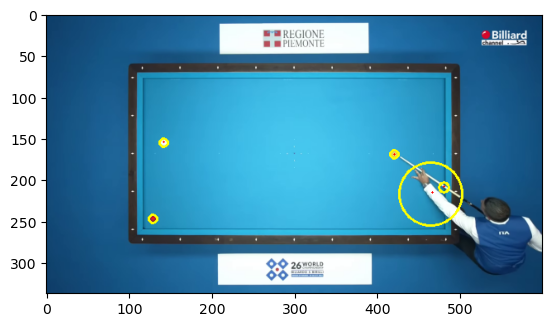

In [66]:
cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
centers = []  # Lista per memorizzare i centri delle palle rilevate

# Procedi solo se è stato trovato almeno un contorno
if len(cnts) > 0:
    # Itera su tutti i contorni rilevati
    for c in cnts:
        # Calcola il cerchio minimo che racchiude il contorno e il centroide
        ((x, y), radius) = cv.minEnclosingCircle(c)
        M = cv.moments(c)
        
        # Calcola il centroide solo se il momento centrale è diverso da zero
        if M["m00"] != 0:
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        else:
            center = None
        
        # Procedi solo se il raggio soddisfa una dimensione minima
        if radius > 2:
            # Disegna il cerchio e il centroide sul frame
            cv.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
            cv.circle(frame, center, 1, (0, 0, 255), -1)
            centers.append(center)  # Aggiungi il centro alla lista dei centri
            
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.show()